In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

# System set up

In [2]:
N = 100
omega = 1.
r = 0.2
n = 0.8

# parameter for a new model
phi = np.pi / 4.

# time interval
t = np.linspace(0, 30, 1000)

# initial condition
rho0 = ket2dm(coherent(N, 1 + 3j)) # ket2dm(basis(N, 10))

# harmonic oscilator
a = destroy(N)
H = omega * (a.dag() * a + 0.5)

# momentum operator
p = 1j * np.sqrt(0.5 * omega) * (a.dag() - a)

# coordinate operator
x = np.sqrt(0.5 / omega) * (a.dag() + a)

# Collapse operators for damped harmonic oscillator
damped_harmonic_osc = [np.sqrt(r * (2. * n + 1)) * a,  np.sqrt(r * (2. * n - 1)) * a.dag()]

# Parameters for new model
assert n >= 0.5, "No model exists for given n"

C2 = 2 * n / omega + np.sqrt(4. * n ** 2 - 1.) * np.cos(phi) / omega
C1 = np.sqrt(4. * n ** 2 - 1.) * np.sin(phi)

new_model = [((C1 - 1j) * x + C2 * p) * np.sqrt(r / C2)]

# Propagate

In [3]:
damped_ho_results = mesolve(H, rho0, t, c_ops=damped_harmonic_osc, e_ops=[x, p, H, p ** 4])
new_model_results = mesolve(H, rho0, t, c_ops=new_model, e_ops=[x, p, H, p ** 4])

# Numerically verify Ehrenfest relations

In [4]:
def verify_ehrenfest(results):
    """
    Produce plots for each Ehrenfest relation comparing RHS vs LHS.
    """
    x, p, H, _ = results.expect
    dt = t[1] - t[0]
    
    ###################################################
    
    #plt.title("Error in the first Ehrenfest relation, $\\left| d\\langle x \\rangle/dt - \\langle p \\rangle + r \\langle x \\rangle \\right|$")

    lhs = np.gradient(x, dt)
    rhs = p - r * x
    
    plt.semilogy(
        t, np.abs(lhs - rhs),
        '-',
        label="$\\left| d\\langle x \\rangle/dt - \\langle p \\rangle + r \\langle x \\rangle \\right|$",
    )
    plt.xlabel('time')
    
    #plt.show()
    
    ###################################################
    
    # plt.title("Error in the second Ehrenfest relation, $\\left| d\\langle p \\rangle/dt +\omega^2 \\langle x \\rangle + r \\langle p \\rangle \\right|$")

    lhs = np.gradient(p, dt)
    rhs = -omega ** 2 * x -r * p
    
    plt.semilogy(
        t, np.abs(lhs - rhs),
        '--',
        label="$\\left| d\\langle p \\rangle/dt +\omega^2 \\langle x \\rangle + r \\langle p \\rangle \\right|$",
    )
    plt.xlabel('time')
    
    #plt.show()
    
    ###################################################
    
    # plt.title("Error in the third Ehrenfest relation, $\\left| d\\langle H \\rangle/dt -2r(\omega n - \\langle H \\rangle)\\right|$")

    lhs = np.gradient(H, dt)
    rhs = 2. * r * (omega * n - H)
    
    plt.semilogy(
        t, np.abs(lhs - rhs),
        '-.',
        label="$\\left| d\\langle H \\rangle/dt -2r(\omega n - \\langle H \\rangle)\\right|$",
    )
    
    plt.xlabel('time')
    plt.ylabel('error')
    plt.legend()
    
    plt.show()
    

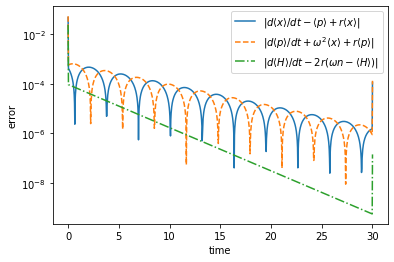

In [5]:
verify_ehrenfest(damped_ho_results)

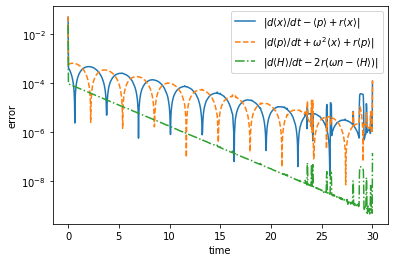

In [6]:
verify_ehrenfest(new_model_results)

# Difference between new model and damped harmonic oscillator

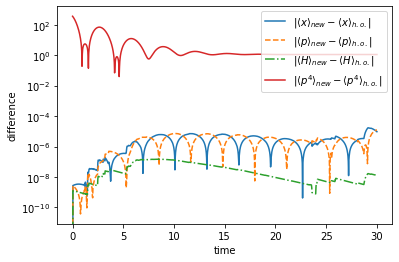

In [7]:
plt.semilogy(
    t, 
    np.abs(new_model_results.expect[0] - damped_ho_results.expect[0]),
    '-',
    label="$\\left| \\langle x \\rangle_{new} - \\langle x \\rangle_{h.o.} \\right|$"
)
plt.semilogy(
    t, 
    np.abs(new_model_results.expect[1] - damped_ho_results.expect[1]),
    '--',
    label="$\\left| \\langle p \\rangle_{new} - \\langle p \\rangle_{h.o.} \\right|$"
)
plt.semilogy(
    t, 
    np.abs(new_model_results.expect[2] - damped_ho_results.expect[2]),
    '-.',
    label="$\\left| \\langle H \\rangle_{new} - \\langle H \\rangle_{h.o.} \\right|$"
)
plt.semilogy(
    t, 
    np.abs(new_model_results.expect[2] - damped_ho_results.expect[3]),
    label="$\\left| \\langle p^4 \\rangle_{new} - \\langle p^4 \\rangle_{h.o.} \\right|$"
)
plt.xlabel('time')
plt.ylabel('difference')
plt.legend()
plt.savefig('diff_observable.pdf')
plt.show()

# Comparing steady states

In [8]:
rho_ho_ss = steadystate(H, damped_harmonic_osc)
rho_new_ss = steadystate(H, new_model)

In [9]:
delta_rho = rho_ho_ss - rho_new_ss

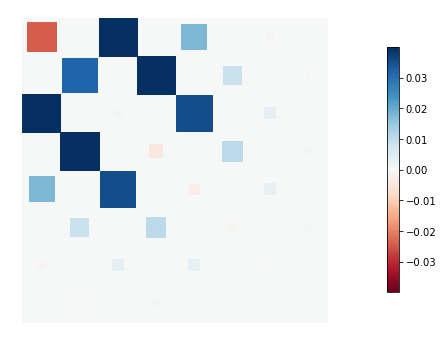

In [10]:
hinton(delta_rho[:8, :8])
plt.savefig("diff_stedy_states.pdf")
plt.show()